# Predicting happiness from sleeping hours
My friend had an old diary in which she recorded among other things how much she slept the previous day and how happy she was. I was curious to see if there was any correlation between these. So to do this I built a simple bayesian network.

In [4]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Load the data

Since there was not that much data I just directly typed the values into this notebook. The sleep is given in hours and the happiness is given on a scale from 0 to 6. I rescaled the happiness from 1 to 5 as that is arguably more intuitive. We can also plot sleep against happiness and see that there is no obvious correlation.

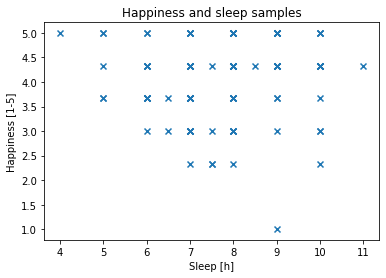

In [5]:
data_sleep = np.array([6, 9, 7.5, 10, 6.5, 10, 10, 6, 8, 6, 6, 6, 10, 9, 7, 7, 7.5, 8, 8, 9, 9, 7, 7, 5, 7, 7, 9, 9, 6, 7, 7, 7, 9, 7, 5, 4, 11, 10, 8, 8, 6, 9, 10, 7, 7, 7, 8, 8, 8, 7, 8, 8, 9, 10, 7, 8, 5, 7, 6, 10, 7, 7, 8, 6, 7, 10, 10, 10, 8, 5, 9, 9, 10, 9, 7, 8, 8, 8, 8, 8, 9, 9, 10, 6, 7, 7, 8, 9, 9, 7.5, 8, 8, 8, 8, 9, 10, 6, 6, 6.5, 8, 7, 5, 7.5, 8.5, 7, 7, 9], dtype=np.float32)
data_happiness = np.array([6, 5, 2, 5, 3, 5, 3, 4, 5, 5, 3, 5, 2, 4, 3, 6, 3, 4, 5, 6, 5, 4, 3, 6, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 6, 6, 5, 3, 5, 6, 4, 6, 5, 5, 3, 3, 4, 3, 6, 4, 4, 3, 6, 5, 6, 4, 4, 5, 6, 5, 5, 4, 5, 4, 6, 5, 6, 6, 6, 4, 3, 4, 4, 0, 6, 5, 6, 3, 5, 6, 5, 6, 6, 5, 4, 3, 5, 6, 6, 2, 5, 3, 4, 6, 6, 5, 5, 4, 4, 2, 5, 5, 5, 5, 2, 4, 5], dtype=np.float32)
data_happiness = data_happiness * 4 / 6 + 1

plt.scatter(data_sleep, data_happiness, marker="x")
plt.title("Happiness and sleep samples")
plt.xlabel("Sleep [h]")
plt.ylabel("Happiness [1-5]")
plt.show()

# Modelling
So now that we have the data we need to specify a model. I chose a simple linear model with the standard deviation `sigma`, weight `w` and bias `b` and likelihood `P(sleep | happy, sigma, w, b) = N(w * happy + b, sigma)`.
Now we need to specify the priors of the variables which is shown in the table below. Note that f or the bias we chose its mean to lie fairly certainly at the mean of the data.

| Variable | Prior |
|----------|--------|
| `sigma` | `Half-Normal(0, 2)` |
| `w` | `Normal(0, 2)` |
| `b` | `Normal(mean(happiness data), 0.5)` |

Now that we have the priors and likelihood we can run a sampling algorithm (ie. Metropolis-Hastings here) to sample from the posterior `P(happy | sleep, sigma, w, b)`.

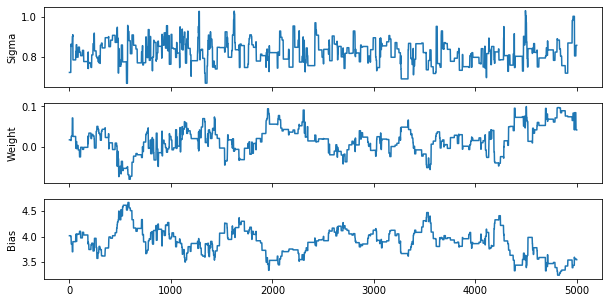

In [9]:
prior_sigma = stats.halfnorm(0, 2)
prior_weight = stats.norm(0, 2)
prior_bias = stats.norm(np.mean(data_happiness), 0.5)

def calculate_log_joint_prob(sigma, weight, bias):
    log_p_sigma = prior_sigma.logpdf(sigma)
    log_p_weight = prior_weight.logpdf(weight)
    log_p_bias = prior_bias.logpdf(bias)

    log_joint_prob = log_p_sigma + log_p_weight + log_p_bias

    for sleep, happiness in zip(data_sleep, data_happiness):
        log_joint_prob += stats.norm(weight * sleep + bias, sigma).logpdf(happiness)

    return log_joint_prob

def should_accept(joint_log_prob_new, joint_log_prob_old):
    return joint_log_prob_new - joint_log_prob_old > np.log(np.random.uniform())

def random_walk(value, scale=0.1):
    """Calculate next sample using N(value, scale)"""
    return np.random.normal(loc=value, scale=scale)

np.random.seed(0)

num_samples = 5000
num_burn_in = 5000

sigma_samples = np.empty(num_samples, dtype=np.float32)
weight_samples = np.empty(num_samples, dtype=np.float32)
bias_samples = np.empty(num_samples, dtype=np.float32)

# Set initial values and calculate their joint probability
sigma = 1
weight = 0
bias = np.mean(data_happiness)
joint_log_prob = calculate_log_joint_prob(sigma, weight, bias)

# Draw some samples using Metropolis-Hastings
for i in range(num_samples + num_burn_in):
    # Get the next weight and calculate its joint probability
    next_sigma, next_weight, next_bias = random_walk([sigma, weight, bias])
    next_joint_log_prob = calculate_log_joint_prob(next_sigma, next_weight, next_bias)

    # Check if we should keep the old or the new weight
    if should_accept(next_joint_log_prob, joint_log_prob):
        sigma, weight, bias = next_sigma, next_weight, next_bias
        joint_log_prob = next_joint_log_prob

    # Throw away the first samples as they are used for initialization
    if i >= num_burn_in:
        # Add variables to samples (will be either the previous one or the new one)
        sigma_samples[i - num_burn_in] = sigma
        weight_samples[i - num_burn_in] = weight
        bias_samples[i - num_burn_in] = bias

fig, ax = plt.subplots(3, figsize=[10, 5], sharex=True)
# Plot the sampling trajectory
ax[0].set_ylabel("Sigma")
ax[0].plot(sigma_samples)

ax[1].set_ylabel("Weight")
ax[1].plot(weight_samples)

ax[2].set_ylabel("Bias")
ax[2].plot(bias_samples)

plt.show()

# Plot histograms of variables
Now samples holds the list of posterior samples for the variables. We can plot a histogram of these and see how certain they are given this data.

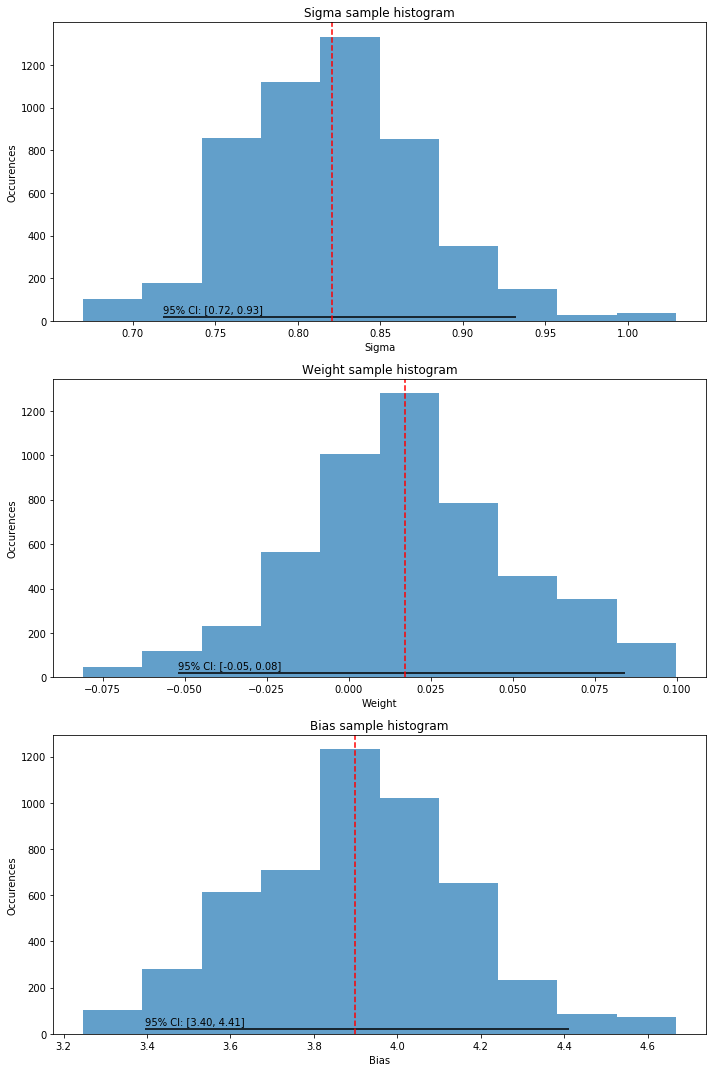

In [10]:
def plot_hist(name, samples, ax, title):
    quantiles = np.quantile(samples, [0.025, 0.975])
    ax.set_xlabel(name)
    ax.set_ylabel("Occurences")
    ax.set_title(title)
    ax.hist(samples, bins=10, alpha=0.7)
    ax.axvline(np.mean(samples), c="red", linestyle="dashed")
    ax.annotate("95%% CI: [%.2f, %.2f]" % (quantiles[0], quantiles[1]), [quantiles[0], 40])
    ax.hlines(20, quantiles[0], quantiles[1])

fig, ax = plt.subplots(3, figsize=[10, 15])
plot_hist("Sigma", sigma_samples, ax[0], "Sigma sample histogram")
plot_hist("Weight", weight_samples, ax[1], "Weight sample histogram")
plot_hist("Bias", bias_samples, ax[2], "Bias sample histogram")
plt.tight_layout()
plt.show()

# Results
From these histograms we can see that the average happiness is about `3.9`. There appears to be no correlation between hours of sleep and happiness in the data because almost all weight samples are close to zero and the variance is almost only described by the noise.
We can now also sample from the posterior predictive distribution to generate more samples.

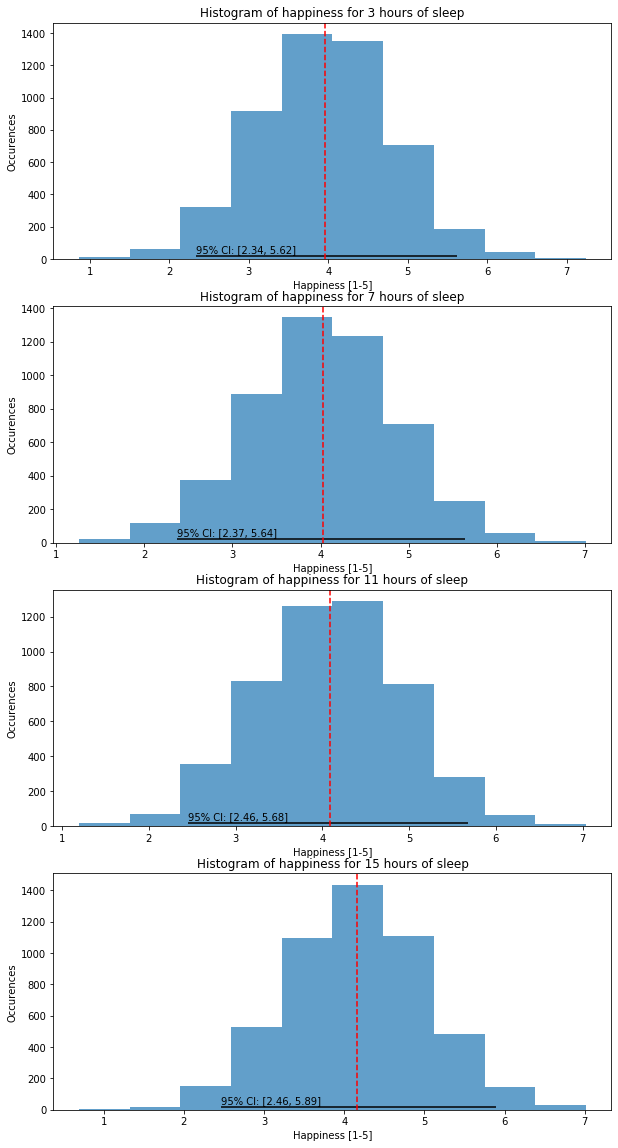

In [11]:
def sample_happiness(sleep):
    happiness_samples = np.empty(num_samples, dtype=np.float32)
    for i in range(num_samples):
        sigma, weight, bias = sigma_samples[i], weight_samples[i], bias_samples[i]
        happiness_samples[i] = np.random.normal(loc=weight * sleep + bias, scale=sigma)
    return happiness_samples

sleeps = [3, 7, 11, 15]

fig, axes = plt.subplots(len(sleeps), figsize=[10, 20])
for sleep, ax in zip(sleeps, axes):
    happiness_samples = sample_happiness(sleep)
    plot_hist("Happiness [1-5]", happiness_samples, ax, "Histogram of happiness for %d hours of sleep" % sleep)
plt.show()

# Conclusion
As expected changing the hours of sleep doesn't change the happiness much. Now this does not say that sleeping more or less does not affect ones happiness. For example it could be the case that during holidays ones sleeping patterns are more chaotic for example having very low and very high amounts of sleep. During the holidays one would feel more happy in general so the very low and very high amounts of sleep would appear to correlate even though it's just the missing holiday factor relating them. Another point is that a linear model might not be fitting here as you can see from the data that few and a lot of hours of sleep has higher happiness than the average amount of sleep.